Goal: We want to analyze range of overlap between source and target populations in feature age such that it ganrantees good performance on OTTEHR

In [86]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from mimic_common import *
import numpy as np
import os
import pandas as pd

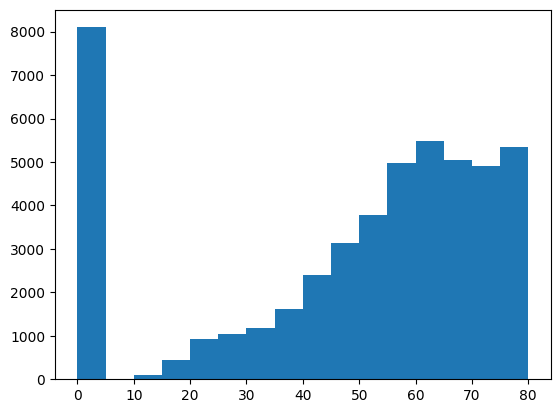

In [87]:
# Visualize age distribution 
mimic_iii_df = pd.read_csv(os.path.join(mimic_output_dir, 'admission_patient_diagnosis_ICD_with_age.csv'), index_col=None, header=0, converters={'ICD codes': literal_eval})

bins = np.arange(0, 81, 5)
plt.hist(mimic_iii_df['age'], bins=bins)
plt.show()

/tmp/ipykernel_2232028/3748309253.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)


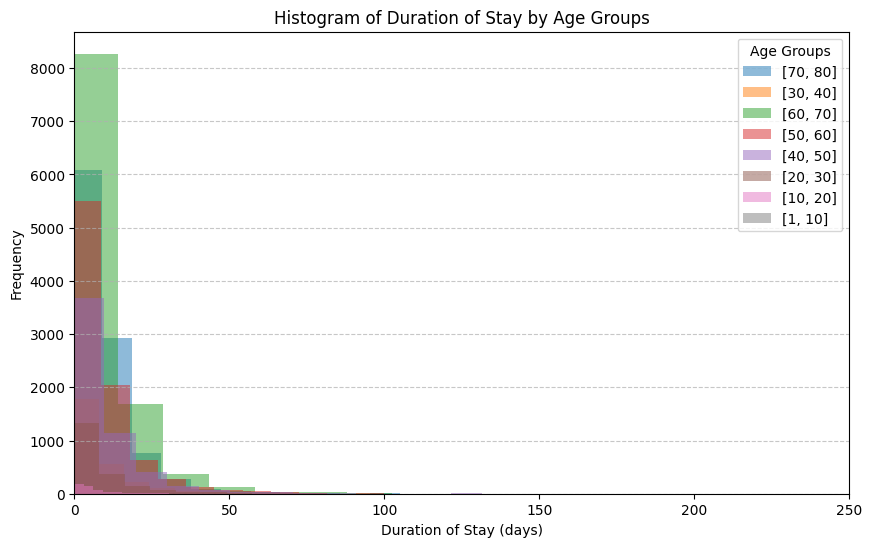

In [88]:
# Visualize the histogram for duration of stay in hospital by age 

import pandas as pd
import matplotlib.pyplot as plt



# Extract age and duration columns
data = mimic_iii_df[['age', 'duration']]

# Define age groups
bins = [1, 10, 20, 30, 40, 50, 60, 70, 80]
labels = [f"[{bins[i]}, {bins[i+1]}]" for i in range(len(bins)-1)]
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Convert duration from minutes to days for better interpretation
data['duration_days'] = data['duration'] / (60 * 60 * 24)

# Plot the histogram of duration by age groups
plt.figure(figsize=(10, 6))
for group in data['age_group'].unique():
    if str(group) == 'nan':
        continue
    subset = data[data['age_group'] == group]
    plt.hist(subset['duration_days'], bins=20, alpha=0.5, label=str(group))

plt.xlim(0, 250)
plt.title('Histogram of Duration of Stay by Age Groups')
plt.xlabel('Duration of Stay (days)')
plt.ylabel('Frequency')
plt.legend(title="Age Groups")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [89]:
# Function to calculate overlap ratio
def calc_overlap(source, target):
    """ 
    Function to calculate the overlap ratio bewteen target range and source range
    """
    overlap = max(0, min(target[1], source[1]) - max(target[0], source[0]))
    total_range = source[1] - source[0]
    return overlap / total_range

In [96]:
# source_range = [30, 50]
# target_ranges = [[1, 20], [5, 25], [10, 30], [15, 35], [20, 40], [25, 40], [30, 50], [35, 55], [40, 60], [45, 65], [50, 70], [55, 75], [60, 80]]
source_range = [50, 70]
target_ranges = [[25, 45], [30, 50], [35, 55], [45, 65], [50, 70], [55, 75], [60, 80]]
group_name = 'age'
trans_metrics = ['OT', 'TCA', 'CA', 'GFK', 'RSD', 'daregram']
mae_stats = []
mae_vars = []
rmse_stats = []
rmse_vars = []

for trans_metric in trans_metrics:
    cur_mae_stats = []
    cur_mae_vars = []
    cur_rmse_stats = []
    cur_rmse_vars = []
    for target_range in target_ranges:
        score_path = os.path.join(mimic_output_dir, f"{group_name}_{target_range}_to_{source_range}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=None)
        if trans_metric == 'daregram' or trans_metric == 'RSD':
            cur_mae_stats.append(np.median(score_df['target_mae'])) 
            cur_mae_vars.append(np.var(score_df['target_mae']))
            cur_rmse_stats.append(np.median(score_df['target_rmse']))
            cur_rmse_vars.append(np.var(score_df['target_rmse']))
        else:
            cur_mae_stats.append(np.median(score_df['trans_target_mae'])) 
            cur_mae_vars.append(np.var(score_df['trans_target_mae'])) 
            cur_rmse_stats.append(np.median(score_df['trans_target_rmse']))
            cur_rmse_vars.append(np.var(score_df['trans_target_rmse']))

    mae_stats.append(cur_mae_stats)
    mae_vars.append(cur_mae_vars)
    rmse_stats.append(cur_rmse_stats)
    rmse_vars.append(cur_rmse_vars)
        
print(mae_stats)


[[687568.3479207701, 689820.0421911865, 667921.8758494544, 552971.6239295227, 422875.0157672266, 597147.6401149351, 536681.3470194717], [659752.9588489234, 613002.4834083791, 455731.42864490265, 369204.9283259609, 376972.7981249816, 382654.9416265177, 376810.89689952775], [1209064.9289163784, 1730464.9614540697, 1125226.695911675, 1216769.449021096, 982334.9728792589, 1443522.9969312428, 1056971.7593521266], [875773.1913924369, 804293.6709954776, 748845.8610930439, 674465.5151763657, 513137.1244620037, 694139.6342676154, 629518.4839367229], [821318.6046756796, 890983.9620629752, 922076.6809498197, 822309.641827091, 867909.0817489872, 895351.4949443487, 899844.9289695697], [847613.5306258788, 883676.251118164, 875396.2414278429, 872546.845195611, 878092.2533546536, 867661.1249986435, 868257.577548325]]


/tmp/ipykernel_2232028/1550405525.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  unique_colors = cm.get_cmap('tab10', len(trans_metrics))


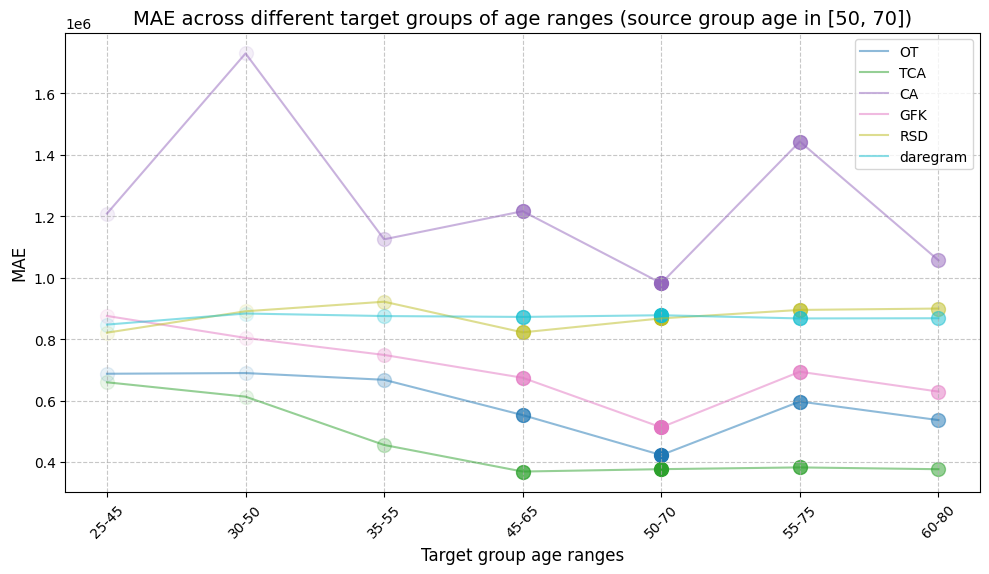

In [97]:
# Investigate MAE robustness

# Calculate overlap ratios for each target range
overlap_ratios = [calc_overlap(target, source_range) for target in target_ranges]
for i, item in enumerate(overlap_ratios):
    if item == 0:
        overlap_ratios[i] = 0.1

# Convert target ranges into a readable format for visualization
target_range_labels = [f"{r[0]}-{r[1]}" for r in target_ranges]

# Generate unique colors for each trans_metric
unique_colors = cm.get_cmap('tab10', len(trans_metrics))

# Create the plot
plt.figure(figsize=(10, 6))
for idx, (trans_metric, cur_mae_stats) in enumerate(zip(trans_metrics, mae_stats)):
    color = unique_colors(idx)
    plt.plot(target_range_labels, cur_mae_stats, color=color, linestyle='-', alpha=0.5, label=f"{trans_metric}")
    for i, (label, mae, overlap) in enumerate(zip(target_range_labels, cur_mae_stats, overlap_ratios)):
        plt.scatter(label, mae, color=color, alpha=overlap, s=100)

# Add labels, title, and grid
plt.xlabel("Target group age ranges", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.title("MAE across different target groups of age ranges (source group age in [50, 70])", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


# Show the plot
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, f"age_MAE_robustness.pdf")
plt.savefig(fig_path)

In [92]:
# TODO: TCA better at continuous distributional shift. OTTEHR is better at catogorical distributional shift, 
# # Investigate MAE robustness

# # Calculate overlap ratios for each target range
# overlap_ratios = [calc_overlap(target, source_range) for target in target_ranges]
# for i, item in enumerate(overlap_ratios):
#     if item == 0:
#         overlap_ratios[i] = 0.1

# # Convert target ranges into a readable format for visualization
# target_range_labels = [f"{r[0]}-{r[1]}" for r in target_ranges]

# # Generate unique colors for each trans_metric
# unique_colors = cm.get_cmap('tab10', len(trans_metrics))

# # Create the plot
# plt.figure(figsize=(10, 6))
# for idx, (trans_metric, cur_mae_vars) in enumerate(zip(trans_metrics, mae_vars)):
#     color = unique_colors(idx)
#     plt.plot(target_range_labels, cur_mae_vars, color=color, linestyle='-', alpha=0.5, label=f"{trans_metric}")
#     for i, (label, mae, overlap) in enumerate(zip(target_range_labels, cur_mae_vars, overlap_ratios)):
#         plt.scatter(label, mae, color=color, alpha=overlap, s=100)

# # Add labels, title, and grid
# plt.xlabel("Target group age ranges", fontsize=12)
# plt.ylabel("MAE", fontsize=12)
# plt.title("MAE across different target groups of age ranges (source group age in [50, 70])", fontsize=14)
# plt.xticks(rotation=45, fontsize=10)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)


# # Show the plot
# plt.tight_layout()
# # fig_path = os.path.join(mimic_output_dir, f"age_MAE_robustness.pdf")
# # plt.savefig(fig_path)

/tmp/ipykernel_2232028/2815251064.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  unique_colors = cm.get_cmap('tab10', len(trans_metrics))


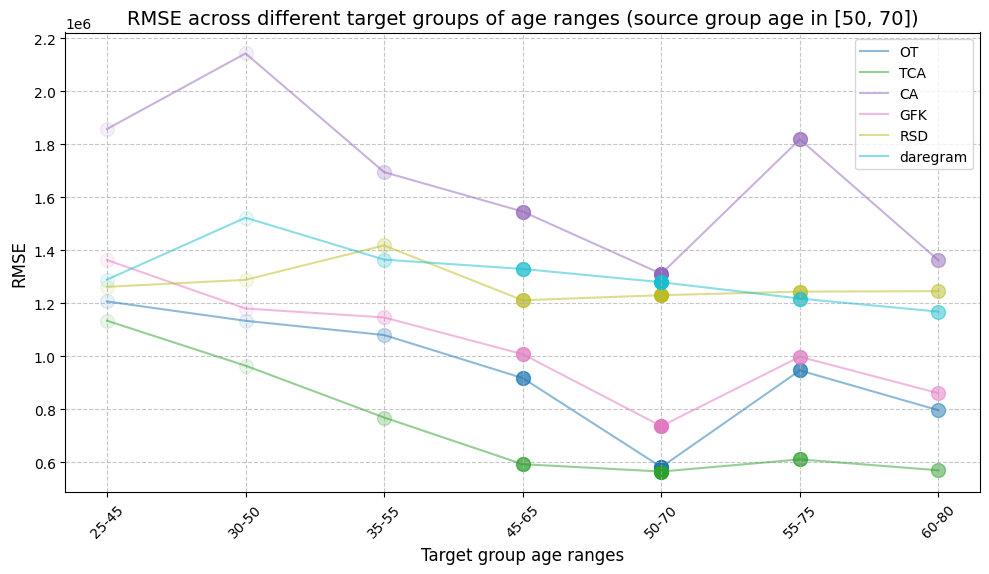

In [93]:
# Investigate RMSE robustness

# Calculate overlap ratios for each target range
overlap_ratios = [calc_overlap(target, source_range) for target in target_ranges]
for i, item in enumerate(overlap_ratios):
    if item == 0:
        overlap_ratios[i] = 0.1

# Convert target ranges into a readable format for visualization
target_range_labels = [f"{r[0]}-{r[1]}" for r in target_ranges]

# Generate unique colors for each trans_metric
unique_colors = cm.get_cmap('tab10', len(trans_metrics))

# Create the plot
plt.figure(figsize=(10, 6))
for idx, (trans_metric, cur_rmse_stats) in enumerate(zip(trans_metrics, rmse_stats)):
    color = unique_colors(idx)
    plt.plot(target_range_labels, cur_rmse_stats, color=color, linestyle='-', alpha=0.5, label=f"{trans_metric}")
    for i, (label, rmse, overlap) in enumerate(zip(target_range_labels, cur_rmse_stats, overlap_ratios)):
        plt.scatter(label, rmse, color=color, alpha=overlap, s=100)

# Add labels, title, and grid
plt.xlabel("Target group age ranges", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE across different target groups of age ranges (source group age in [50, 70])", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


# Show the plot
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, f"age_RMSE_robustness.pdf")
plt.savefig(fig_path)

In [ ]:
# Possible explanations
# Why TCA performs better for continuous splits: OT explicitly computes a transport map that matches individual samples or small clusters of data. In tasks with continuous domain splits, such granular alignment might overfit to the local sample distribution and fail to generalize well across smooth changes in feature space.
# Why OT performs better for categorical splits: TCA assumes that the source and target domains share some structure in their embedding feature space. For categorical splits, where distributions can be entirely distinct (e.g., insurance groups may represent entirely different populations with different behaviors), TCA's MMD-based alignment may fail to meaningfully align the distributions.
